In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as mticker
import duckdb
import time

In [2]:
# https://www.kaggle.com/datasets/marwa80/userbehavior?resource=download
# data_fn = '../data/taobao/UserBehavior.csv'
data_fn = '../data/UserBehavior.csv/UserBehavior.csv'
headers = ['user_id', 'item_id',  'category_id', 'behavior_type', 'timestamp']
df = pd.read_csv(data_fn, header=None, names=headers)

In [3]:
display(df)

,user_id,item_id,category_id,behavior_type,timestamp
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146
...,...,...,...,...,...
100150802,999999,4797808,11120,pv,1512293403
100150803,999999,4613472,4602841,pv,1512293766
100150804,999999,3647364,2304296,pv,1512293792
100150805,999999,1903801,2304296,pv,1512293827


In [11]:
min_range = np.percentile(df['timestamp'], 0.01)
max_range = np.percentile(df['timestamp'], 99.9)

bin_minutes = 60
num_bins = int((max_range-min_range) // (bin_minutes * 60))
print(min_range, max_range)
print(datetime.datetime.utcfromtimestamp(min_range).strftime('%Y-%m-%d %H:%M,'), datetime.datetime.utcfromtimestamp(max_range).strftime('%Y-%m-%d %H:%M,'), num_bins)

hist, bin_edges = np.histogram(df['timestamp'], density=False, bins=num_bins, range=(min_range, max_range))
times = [datetime.datetime.utcfromtimestamp(timestamp).strftime('%m-%d %H:%M') for timestamp in np.arange(num_bins)*(60*bin_minutes)+min_range]

1511426847.3702 1512316224.0
2017-11-23 08:47, 2017-12-03 15:50, 247


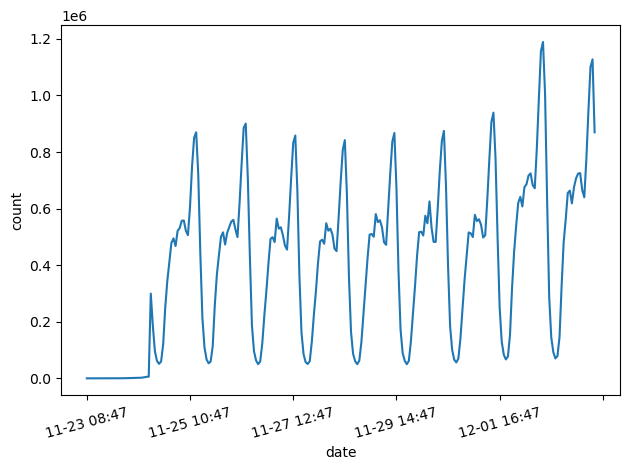

In [12]:
# synthetic data
a = hist
d = times

# make figure + axes
fig, ax = plt.subplots(tight_layout=True)
ax.set_xlabel('date')
ax.set_ylabel('count')

# draw one line
ln1, = ax.plot(hist)


# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return d[int(x)]
    except IndexError:
        return ''

# make and use the formatter
mt = mticker.FuncFormatter(listifed_formatter)
ax.xaxis.set_major_formatter(mt)

# set the default ticker to only put ticks on the integers
loc = ax.xaxis.get_major_locator()
loc.set_params(integer=True)

# rotate the labels
[lab.set_rotation(15) for lab in ax.get_xticklabels()]
plt.show()

In [128]:
start = time.time()
duckdb.sql("""
drop table if exists tmp_user_info
;
create table tmp_user_info
as
select * from read_csv("../data/UserBehavior.csv/UserBehavior.csv",columns = {
        'userid': 'BIGINT',
        'itemid': 'BIGINT',
        'categoryid': 'BIGINT',
        'type': 'VARCHAR',
        'timestamp': 'BIGINT'
    },null_padding=true)
where strftime(to_timestamp(timestamp),'%Y-%m-%d') between '2017-11-25' and '2017-12-03';
DELETE FROM tmp_user_info
WHERE userid is null;
""")
end = time.time()
print(end - start)

5.200192451477051


In [130]:
duckdb.sql("""
drop table if exists new_user_info
;
create table new_user_info
as
select * from tmp_user_info
where userid in (select userid from tmp_user_info group by 1 limit 9512)
""")

In [135]:
duckdb.sql("""
(select count(distinct userid) AS "用户",
count(distinct itemid) AS "商品",
count(distinct categoryid) AS "商品类目",
count(distinct type) AS "行为",
count(distinct timestamp) AS "时间",
count(*) AS "数据量（条）" from new_user_info)
""")

┌───────┬────────┬──────────┬───────┬────────┬──────────────┐
│ 用户  │  商品  │ 商品类目 │ 行为  │  时间  │ 数据量（条） │
│ int64 │ int64  │  int64   │ int64 │ int64  │    int64     │
├───────┼────────┼──────────┼───────┼────────┼──────────────┤
│  9512 │ 378729 │     5793 │     4 │ 462135 │       919549 │
└───────┴────────┴──────────┴───────┴────────┴──────────────┘

In [147]:
timestamps = duckdb.sql("""
           select timestamp from new_user_info
           """)
# print(timestamps)
timestamps_df = timestamps.df()
display(timestamps_df)

min_range = np.percentile(timestamps_df['timestamp'], 0.03)
max_range = np.percentile(timestamps_df['timestamp'], 100)

bin_minutes = 60
num_bins = int((max_range-min_range) // (bin_minutes * 60))
print(datetime.datetime.utcfromtimestamp(min_range).strftime('%m-%d %H:%M,'), datetime.datetime.utcfromtimestamp(max_range).strftime('%m-%d %H:%M,'), num_bins)

hist, bin_edges = np.histogram(df['timestamp'], density=False, bins=num_bins, range=(min_range, max_range))
times = [datetime.datetime.utcfromtimestamp(timestamp).strftime('%m-%d %H:%M') for timestamp in np.arange(num_bins)*(60*bin_minutes)+min_range]

,timestamp
0,1511608596
1,1511609539
2,1511609546
3,1511609566
4,1511609581
...,...
919544,1512225864
919545,1512225947
919546,1512226009
919547,1512227500


11-25 08:03, 12-03 15:59, 199


In [141]:
duckdb.sql("""
           select strftime(to_timestamp(timestamp),'%Y-%m-%d') from new_user_info
           ORDER BY timestamp desc
           limit 100
           """)

┌─────────────────────────────────────────────────┐
│ strftime(to_timestamp("timestamp"), '%Y-%m-%d') │
│                     varchar                     │
├─────────────────────────────────────────────────┤
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│     ·                                           │
│     ·                                           │
│     ·                                           │
│ 2017-12-03                                      │
│ 2017-12-03                                      │
│ 2017-12-03

In [131]:
hour_rate = duckdb.sql("""
                            select strftime(to_timestamp(timestamp),'%H') AS hour,
                            count(userid) AS PV,
                            count(distinct userid) AS UV from new_user_info 
                            group by 1
                            order by 1
                            """).df()
hour_rate

,hour,PV,UV
0,00,48966,5741
1,01,44897,5704
2,02,45748,5655
3,03,59218,6119
4,04,70371,6356
5,05,79378,6522
6,06,79999,6198
7,07,62263,4877
8,08,29267,2873
9,09,13811,1527


Text(0.5, 1.0, 'hour_uv')

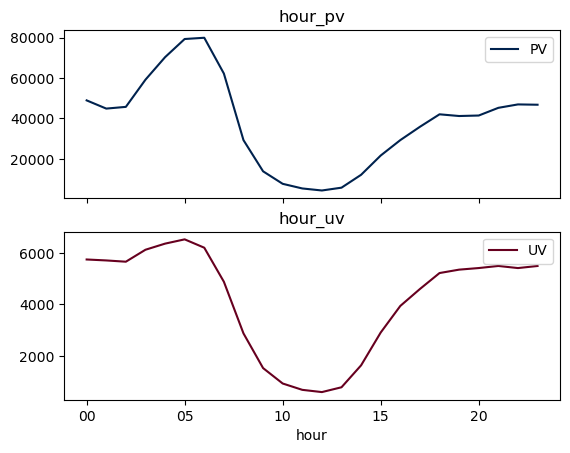

In [132]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
# pv_daily: pandas 对象
# Matplotlib, Pandas , histplot:  柱状图
hour_rate.plot(x='hour', y='PV', ax=axes[0], colormap='cividis')
hour_rate.plot(x='hour', y='UV', ax=axes[1], colormap='RdGy')
axes[0].set_title('hour_pv')
axes[1].set_title('hour_uv')

In [133]:
day_rate = duckdb.sql("""
                            select strftime(to_timestamp(timestamp),'%m-%d') AS DAY,
                            count(userid) AS PV,
                            count(distinct userid) AS UV 
                            from new_user_info 
                            group by 1
                            order by 1
                            """).df()
print(day_rate)

     DAY      PV    UV
0  11-25  102829  6852
1  11-26  102482  6844
2  11-27   97477  6835
3  11-28   96979  6865
4  11-29  100316  6956
5  11-30   99560  7054
6  12-01  120100  7941
7  12-02  134120  8564
8  12-03   65686  6400


Text(0.5, 1.0, 'uv_daily')

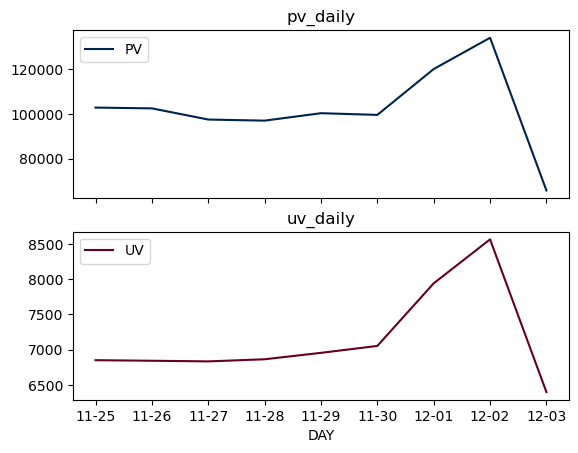

In [134]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
# pv_daily: pandas 对象
# Matplotlib, Pandas , histplot:  柱状图
day_rate.plot(x='DAY', y='PV', ax=axes[0], colormap='cividis')
day_rate.plot(x='DAY', y='UV', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')